<a href="https://colab.research.google.com/github/OtolaHan/Otola_Han_KAAN/blob/main/Exercise_5_Question1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Обучение  CNN на полном наборе данных Cats-v-dogs
От вас потребуется некоторая предварительная обработка, потому что
набор данных не разделен на обучение и проверку.

In [ ]:
# В этом блоке кода находятся все необходимые импорты
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from shutil import copyfile

Сначала надо получить данные.

In [ ]:
# Этот блок кода загружает полный набор фотографий кошек и собак и сохраняет его как
# cats-and-dogs.zip. Затем он распаковывает его в /tmp.
# Будет создан каталог tmp/PetImages, содержащий подкаталоги
# под названием 'Cat' и 'Dog'.
# Если URL не работает,
# зайдите на https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765


!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()


--2024-04-15 07:20:51--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.78.8.170, 2600:1407:21:2b7::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.78.8.170|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.67M   124MB/s    in 7.6s    

2024-04-15 07:20:59 (104 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824887076/824887076]



Проверьте, все ли получилось

In [ ]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

# Вывод должен быть примерно такой:
# 12501
# 12501

12501
12501


In [ ]:
# Используйте функцию os.mkdir чтобы создавать каталоги
# Вам понадобится каталог cats-v-dogs и в нем подкаталоги: training и testing.
# В каждом из этих подкаталогов надо будет создать два подкаталога: cats и dogs
try:
        # Создание главного каталога cats-v-dogs
    os.mkdir('/tmp/cats-v-dogs')

    # Создание подкаталогов для тренировочных и тестовых данных
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/testing')

    # Создание каталогов для кошек и собак внутри тренировочного каталога
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')

    # Создание каталогов для кошек и собак внутри тестового каталога
    os.mkdir('/tmp/cats-v-dogs/testing/cats')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError as e:
    print(e)
    print("Один из каталогов уже существует.")

[Errno 17] File exists: '/tmp/cats-v-dogs'
Один из каталогов уже существует.


In [ ]:
import os

# Путь к главному каталогу
base_dir = '/tmp/cats-v-dogs'

# Список путей для всех необходимых подкаталогов
directories = [
    base_dir,
    os.path.join(base_dir, 'training'),
    os.path.join(base_dir, 'testing'),
    os.path.join(base_dir, 'training', 'cats'),
    os.path.join(base_dir, 'training', 'dogs'),
    os.path.join(base_dir, 'testing', 'cats'),
    os.path.join(base_dir, 'testing', 'dogs')
]

# Удаление каталога с содержимым, если он уже существует
def remove_if_exists(path):
    if os.path.exists(path):
        for root, dirs, files in os.walk(path, topdown=False):
            for name in files:
                os.remove(os.path.join(root, name))
            for name in dirs:
                os.rmdir(os.path.join(root, name))
        os.rmdir(path)

# Удаляем главный каталог и все его подкаталоги
remove_if_exists(base_dir)

# Создаем все необходимые каталоги
for directory in directories:
    os.makedirs(directory, exist_ok=True)


###распределение файлов по каталогам в заданной пропорции

Напишите на Python свою функцию **split_data**
со следующими параметрами:

*SOURCE* - каталог, в котором содержатся нужные файлы

*TRAINING* - каталог, в который надо скопировать часть файлов из SOURCE

*TESTING* - каталог, в который надо скопировать оставшуюся часть файлов из SOURCE

*SPLIT_SIZE* - определяет в долях единицы соотношение частей TRAINING и TESTING

**split_data** делит имеющиеся файлы на два набора в указанной пропорции.
например, если SOURCE - PetImages/Cat, а SPLIT_SIZE - .9, то 90% изображений из PetImages/Cat должны копироваться в каталог TRAINING, а 10% изображений - в каталог TESTING

Файлы должны быть выбраны случайно.
Кроме того, все изображения должны быть проверены, и файлы с нулевой длиной не должны копироваться

In [ ]:
# os.listdir(DIRECTORY) - список содержимого этого каталога
# os.path.getsize(fullName)  - размер указанного файла
# copyfile(sourceFullName, destinationFullName) копирует данные из source в destination.
# random.sample(list, len(list)) возвращает перемешанный список указанной длины

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
   # Получаем список всех файлов в исходном каталоге
    all_files = []

    for file_name in os.listdir(SOURCE):
        file_path = os.path.join(SOURCE, file_name)

        # Проверяем размер файла, он должен быть больше 0
        if os.path.getsize(file_path) > 0:
            all_files.append(file_name)
        else:
            print(f"{file_name} имеет нулевую длину, не копируется.")

    # Перемешиваем список файлов
    random.shuffle(all_files)

    # Разделяем файлы на тренировочные и тестовые в соответствии с SPLIT_SIZE
    split_point = int(len(all_files) * SPLIT_SIZE)
    training_files = all_files[:split_point]
    testing_files = all_files[split_point:]

    # Копируем файлы в соответствующие каталоги
    for file_name in training_files:
        copyfile(os.path.join(SOURCE, file_name), os.path.join(TRAINING, file_name))

    for file_name in testing_files:
        copyfile(os.path.join(SOURCE, file_name), os.path.join(TESTING, file_name))

# Задаем пути к каталогам
CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

# ожидаемый вывод:
# 666.jpg имеет нулевую длину, не копируется
# 11702.jpg имеет нулевую длину, не копируется

666.jpg имеет нулевую длину, не копируется.
11702.jpg имеет нулевую длину, не копируется.


проверьте, все ли идет по плану

In [ ]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

# ожидаемый вывод:
# 11250
# 11250
# 1250
# 1250

11250
11250
1250
1250


###Определите модель KERAS для классификации кошек и собак.

Используйте как минимум три сверточных слоя

In [ ]:
# USE AT LEAST 3 CONVOLUTION LAYERS
model = tf.keras.models.Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['acc'])

###Добавляем слой предварительной подготовки данных обучения и валидации.

Используйте Data Generator, как вы делали это раньше.

In [ ]:
TRAINING_DIR = '/tmp/cats-v-dogs/training'
train_datagen = ImageDataGenerator(rescale=1.0/255.)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

VALIDATION_DIR = '/tmp/cats-v-dogs/testing'
validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')



# Ожидаемый вывод
# Found 22498 images belonging to 2 classes.
# Found 2500 images belonging to 2 classes.

Found 22499 images belonging to 2 classes.
Found 2499 images belonging to 2 classes.


Запускаем обучение модели.

*Обратите внимание: при загрузке изображений вы можете получить предупреждения об отсутствии или повреждении данных EXIF. Не беспокойтесь об этом - в изображениях отсутствуют некоторые тэги, это не визуальные данные, которые бы повлияли на тренировку.*

In [ ]:
history = model.fit_generator(train_generator,
                              epochs=15,
                              verbose=1,
                              validation_data=validation_generator)

# Здесь ожидается, что после обучения модели точность будет более 95% как тренировочная, так и при валидации.

Epoch 1/15


<ipython-input-61-daa7af869649>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


1125/1125 [==============================] - 55s 48ms/step - loss: 0.6163 - acc: 0.6596 - val_loss: 0.5271 - val_acc: 0.7419
Epoch 2/15
1125/1125 [==============================] - 53s 47ms/step - loss: 0.4743 - acc: 0.7723 - val_loss: 0.4332 - val_acc: 0.7983
Epoch 3/15
1125/1125 [==============================] - 52s 46ms/step - loss: 0.3979 - acc: 0.8217 - val_loss: 0.4007 - val_acc: 0.8215
Epoch 4/15
1125/1125 [==============================] - 55s 49ms/step - loss: 0.3304 - acc: 0.8547 - val_loss: 0.3508 - val_acc: 0.8507
Epoch 5/15
1125/1125 [==============================] - 51s 46ms/step - loss: 0.2588 - acc: 0.8922 - val_loss: 0.5906 - val_acc: 0.7863
Epoch 6/15
1125/1125 [==============================] - 53s 47ms/step - loss: 0.1796 - acc: 0.9289 - val_loss: 0.5765 - val_acc: 0.8411
Epoch 7/15
1125/1125 [==============================] - 53s 47ms/step - loss: 0.1206 - acc: 0.9560 - val_loss: 0.7509 - val_acc: 0.8071
Epoch 8/15
1125/1125 [==============================] - 53s

Смотрим графики процесса тренировки

Text(0.5, 1.0, 'Training and validation loss')

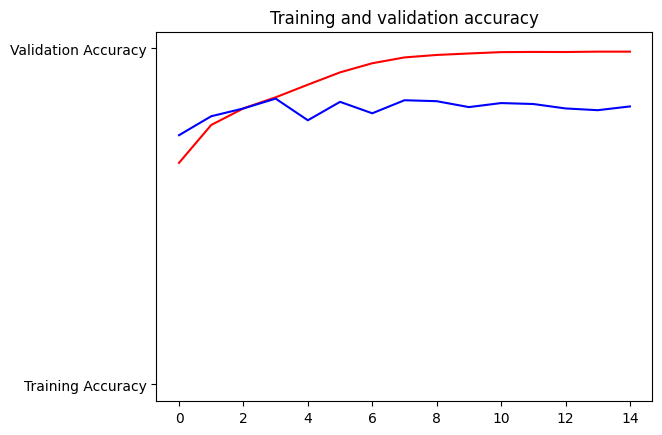

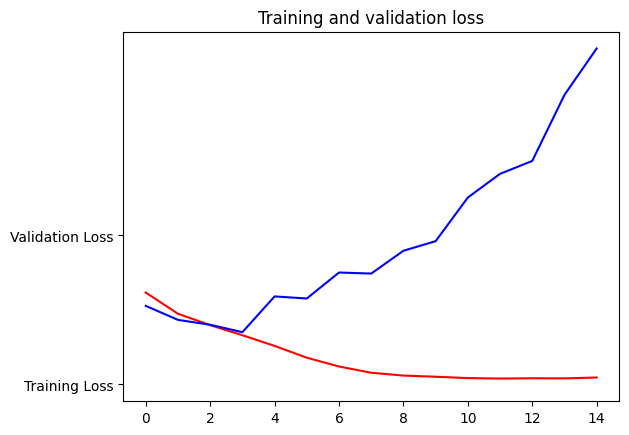

In [ ]:

%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Получить список результатов на тренировочных и тестовых данных
# наборов для каждой эпохи обучения
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # количество эпох

#------------------------------------------------
# Рисуем точность обучения и проверки по эпохам
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Рисуем потери обучения и проверки по эпохам
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

# Желаемый вывод: графики с показателями обучения и валидации

###Запускаем наш классификатор
Это просто для удовольствия. Загрузить изображение и классифицировать его без сбоев

In [ ]:

import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():

  # Предсказание изображений
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x /= 255.0

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " это собака")
  else:
    print(fn + " это кошка")

Saving dogs-1284238_1280.jpg to dogs-1284238_1280.jpg
1/1 [==============================] - 0s 18ms/step
[0.9925258]
dogs-1284238_1280.jpg это собака
